In [23]:
import string

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score

from catboost import CatBoostRegressor, CatBoostClassifier

import nltk

# Домашняя работа

Работаем с отзывами на авиа-компанию:

https://www.kaggle.com/datasets/kanchana1990/singapore-airlines-reviews/data


In [2]:
df = pd.read_csv('../data/singapore_airlines_reviews.csv')
df = df[['rating', 'text', 'title']]
df.head()

,rating,text,title
0,3,We used this airline to go from Singapore to L...,Ok
1,5,The service on Singapore Airlines Suites Class...,The service in Suites Class makes one feel lik...
2,1,"Booked, paid and received email confirmation f...",Don’t give them your money
3,5,"Best airline in the world, seats, food, servic...",Best Airline in the World
4,2,Premium Economy Seating on Singapore Airlines ...,Premium Economy Seating on Singapore Airlines ...




## Easy

Выбрать метрику.

Удалить пунктуацию из датасета.

Преобразовать датасет в BOW или TF-IDF, поделить на треин-тест и спрогнозировать вашей любимой моделью


In [3]:
def pre_process(text):
    text = text.lower()
    translator = str.maketrans('', '', string.punctuation)
    text = text.translate(translator)
    text = ' '.join(text.split())
    return text

df['text'] = df['text'].apply(str).apply(pre_process)
df['title'] = df['title'].apply(str).apply(pre_process)
df.head()

,rating,text,title
0,3,we used this airline to go from singapore to l...,ok
1,5,the service on singapore airlines suites class...,the service in suites class makes one feel lik...
2,1,booked paid and received email confirmation fo...,don’t give them your money
3,5,best airline in the world seats food service a...,best airline in the world
4,2,premium economy seating on singapore airlines ...,premium economy seating on singapore airlines ...


In [4]:
# можно было бы сделать ансабль моделей для оценки текста и заголовка по отдельности, но видимо задание этого не подразумевает, поэтому просто соединим
df['text'] = df['title'] + ' ' + df['text']
df = df[['rating', 'text']]

In [5]:
tfid = TfidfVectorizer()
tfid_result = tfid.fit_transform(df['text']).toarray()

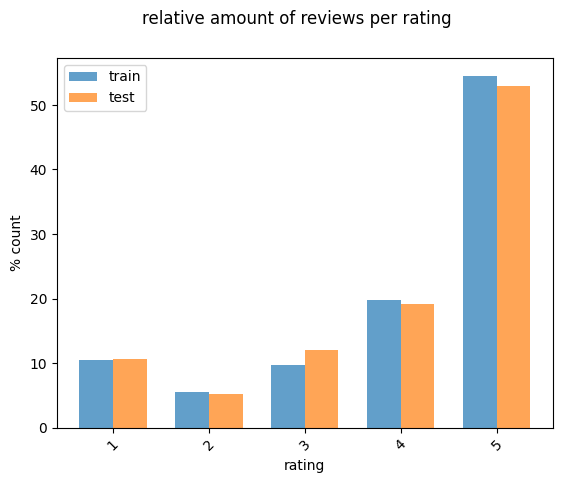

In [6]:
x_train, x_test, y_train, y_test = train_test_split(tfid_result, df['rating'], train_size=0.8, random_state=113)

def plot_bar(y, loc='left', relative=True):
    width = 0.35
    if loc == 'left':
        n = -0.5
    elif loc == 'right':
        n = 0.5
     
    unique, counts = np.unique(y, return_counts=True)
    sorted_index = np.argsort(unique)
    unique = unique[sorted_index]
     
    counts = 100 * counts[sorted_index] / len(y)
    ylabel_text = '% count'
         
    xtemp = np.arange(len(unique))
     
    plt.bar(xtemp + n*width, counts, align='center', alpha=.7, width=width)
    plt.xticks(xtemp, unique, rotation=45)
    plt.xlabel('rating')
    plt.ylabel(ylabel_text)
 
plt.suptitle('relative amount of reviews per rating')
plot_bar(y_train, loc='left')
plot_bar(y_test, loc='right')
plt.legend([
    'train'.format(len(y_train)), 
    'test'.format(len(y_test))
]);


Классы несбалансированны, поэтому как и в задаче со знаками будем использовать f1 + LogReg (показалаа себя очень хорошо).

In [7]:
max_iter = 1000
n_jobs = 12

In [8]:
model_LR = LogisticRegression(max_iter=max_iter, n_jobs=n_jobs, random_state=113)
model_LR.fit(x_train, y_train)

LogisticRegression(max_iter=1000, n_jobs=12)

In [8]:
def show_accuracy(y_test, y_pred):
    print(f1_score(y_test, y_pred, average='weighted'))

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(16, 16))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

0.6459465863888955


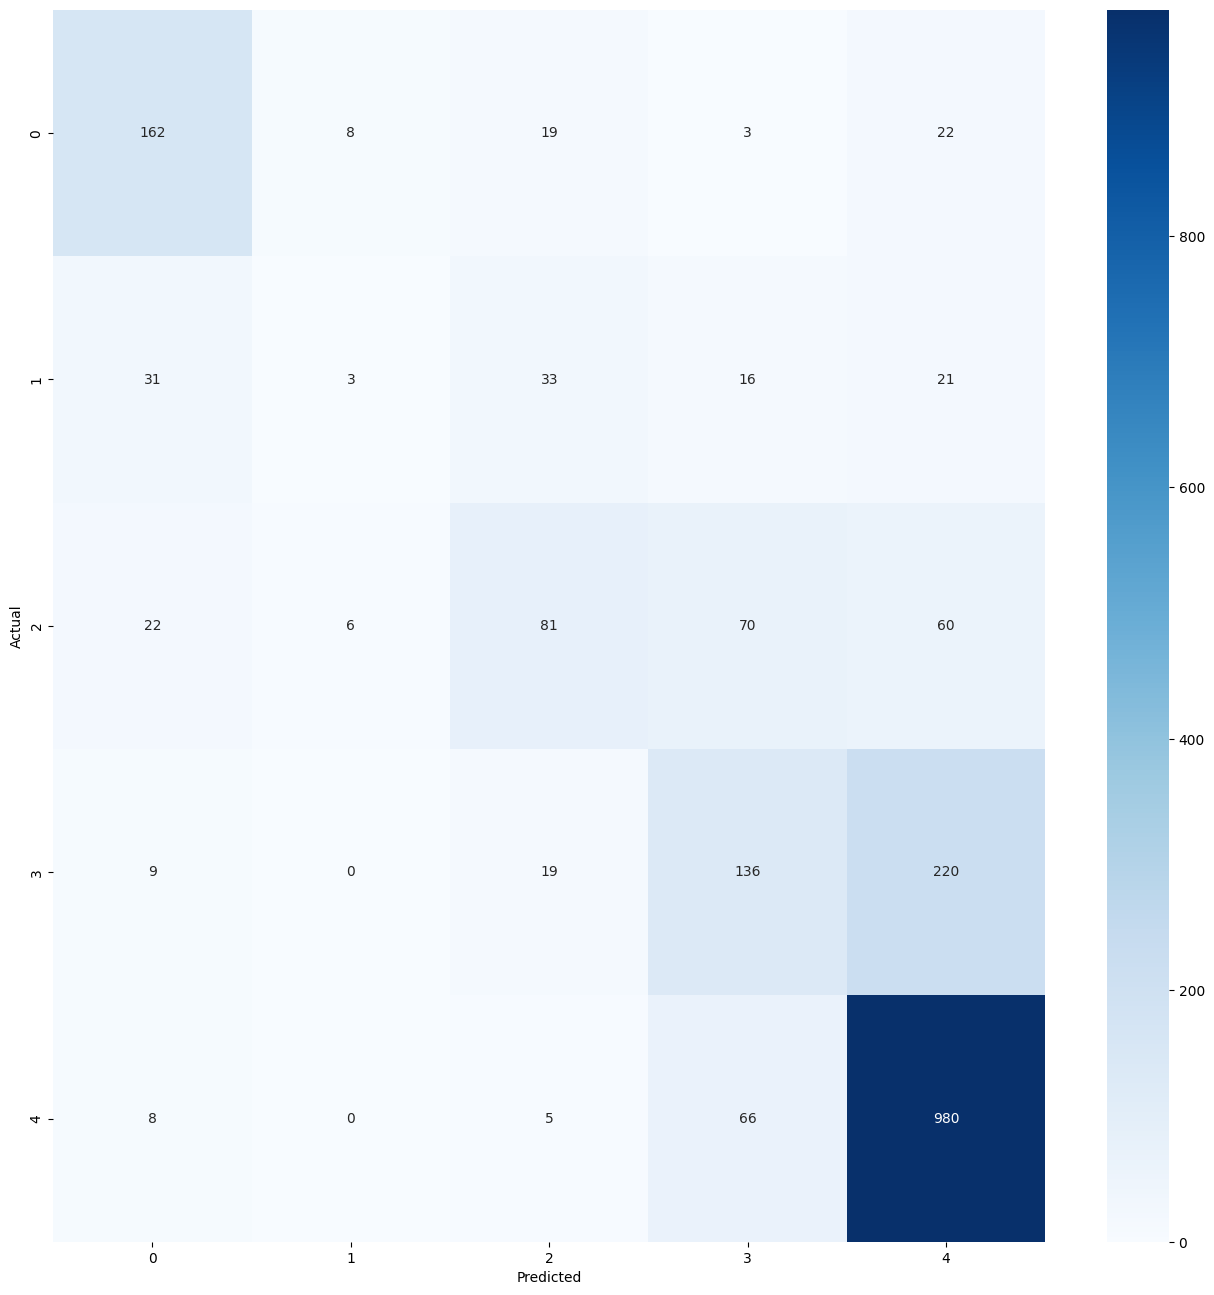

In [10]:
show_accuracy(y_test, model_LR.predict(x_test.reshape(x_test.shape[0], -1)))

Как и ожидалось, модель склонна к завышению оценки (ибо положительные отзывы - это самый мощный класс).


## Normal

Удалить стоп-слова, применить стемминг/лемматизацию. Обучить несколько моделей, подобрать параметры, сделать выводы.

Написать самостоятельно два отзыва - один положительный, один негативный, посмотреть, угадает ли модель.

In [9]:
nltk.download('wordnet')
nltk.download("omw-1.4")

lemmatizer = nltk.stem.WordNetLemmatizer()

def lemmatize(word):
    word = lemmatizer.lemmatize(word, pos="v")
    word = lemmatizer.lemmatize(word, pos="a")
    word = lemmatizer.lemmatize(word, pos="r")
    word = lemmatizer.lemmatize(word, pos="n")
    return word

def remorph(text):
    return ' '.join([lemmatize(word) for word in text.split()])

df['text'] = df['text'].apply(remorph)
df.head()


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\setday\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\setday\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


,rating,text
0,3,ok we use this airline to go from singapore to...
1,5,the service in suit class make one feel like v...
2,1,don’t give them your money book pay and receiv...
3,5,best airline in the world best airline in the ...
4,2,premium economy seat on singapore airline not ...


In [10]:
nltk.download('stopwords')

stopwords = set(nltk.corpus.stopwords.words('english'))

def remove_stopwords(text):
    return ' '.join([word for word in text.split() if word not in stopwords])

df['text'] = df['text'].apply(remove_stopwords)
df.head()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\setday\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,rating,text
0,3,ok use airline go singapore london heathrow is...
1,5,service suit class make one feel like vip serv...
2,1,don’t give money book pay receive email confir...
3,5,best airline world best airline world seat foo...
4,2,premium economy seat singapore airline worth m...


In [11]:
tfid_result = tfid.fit_transform(df['text']).toarray()

x_train, x_test, y_train, y_test = train_test_split(tfid_result, df['rating'], train_size=0.8, random_state=113)

Learning rate set to 0.112561
0:	learn: 1.4970811	test: 1.5040998	best: 1.5040998 (0)	total: 481ms	remaining: 8m 1s
1:	learn: 1.4113539	test: 1.4236621	best: 1.4236621 (1)	total: 702ms	remaining: 5m 50s
2:	learn: 1.3488996	test: 1.3640867	best: 1.3640867 (2)	total: 937ms	remaining: 5m 11s
3:	learn: 1.2993911	test: 1.3159531	best: 1.3159531 (3)	total: 1.15s	remaining: 4m 45s
4:	learn: 1.2589146	test: 1.2774345	best: 1.2774345 (4)	total: 1.36s	remaining: 4m 31s
5:	learn: 1.2246718	test: 1.2458435	best: 1.2458435 (5)	total: 1.59s	remaining: 4m 24s
6:	learn: 1.1972123	test: 1.2212396	best: 1.2212396 (6)	total: 1.8s	remaining: 4m 14s
7:	learn: 1.1723632	test: 1.1977354	best: 1.1977354 (7)	total: 2.03s	remaining: 4m 12s
8:	learn: 1.1508993	test: 1.1780929	best: 1.1780929 (8)	total: 2.25s	remaining: 4m 8s
9:	learn: 1.1338088	test: 1.1623258	best: 1.1623258 (9)	total: 2.48s	remaining: 4m 5s
10:	learn: 1.1164054	test: 1.1457887	best: 1.1457887 (10)	total: 2.71s	remaining: 4m 3s
11:	learn: 1.098

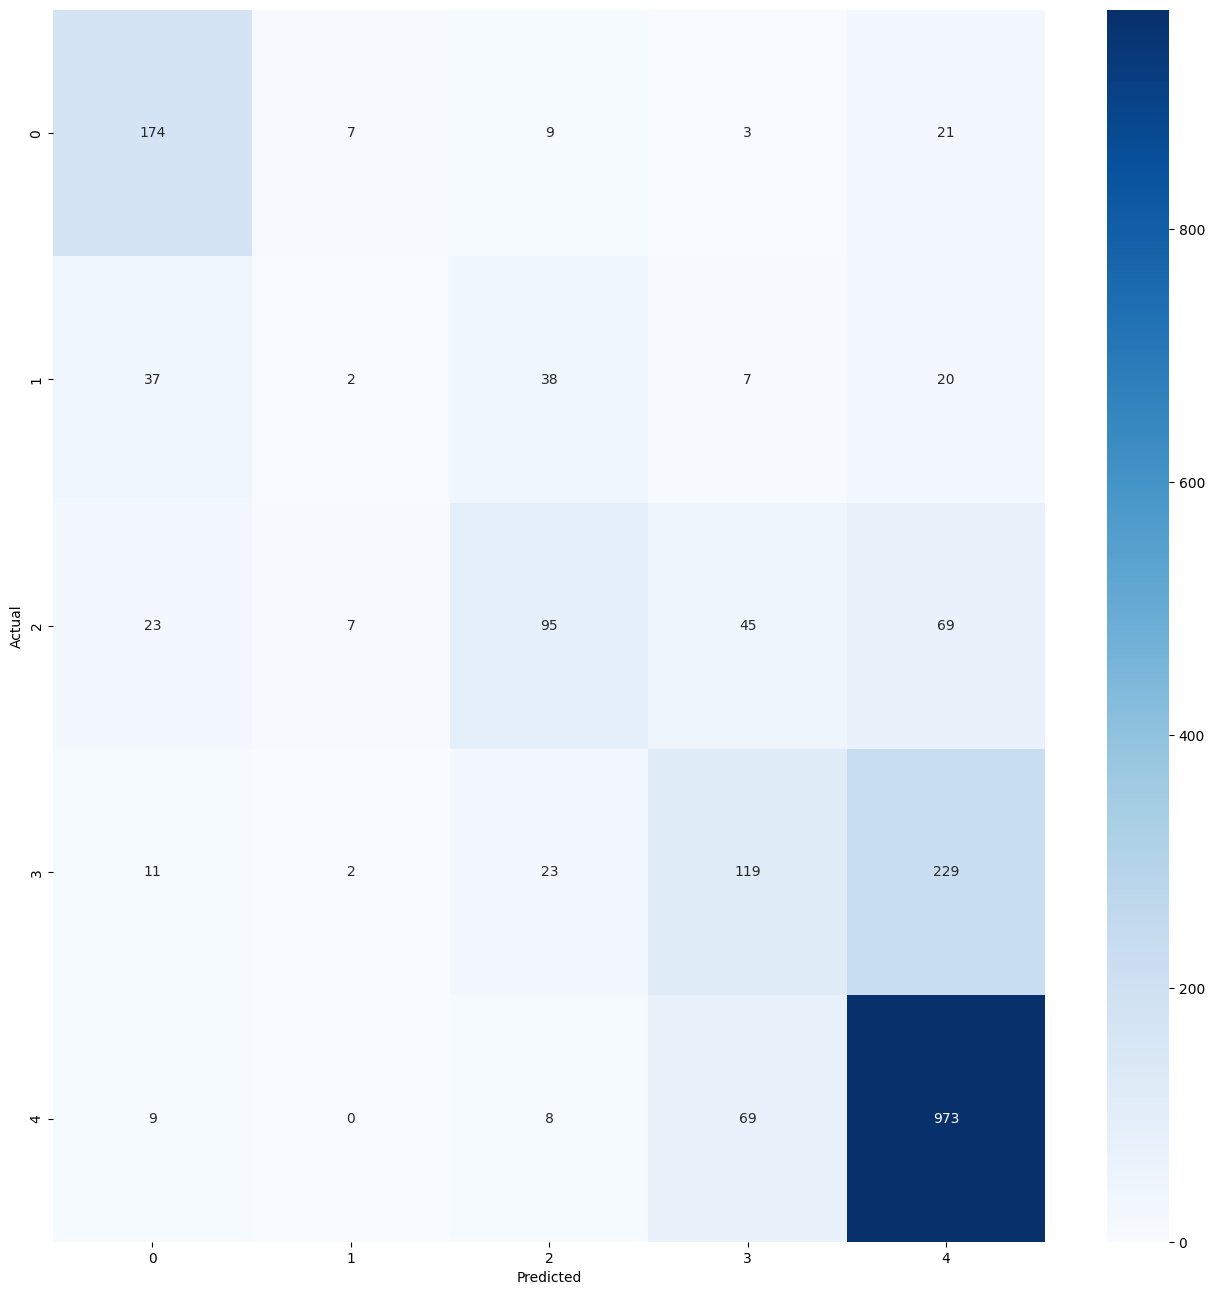

In [14]:
model_CB = CatBoostClassifier(iterations=1000, loss_function='MultiClass')
model_CB.fit(
    x_train, y_train,
    eval_set=(x_test, y_test),
)

show_accuracy(y_test, model_CB.predict(x_test.reshape(x_test.shape[0], -1)))

0.568092273576598


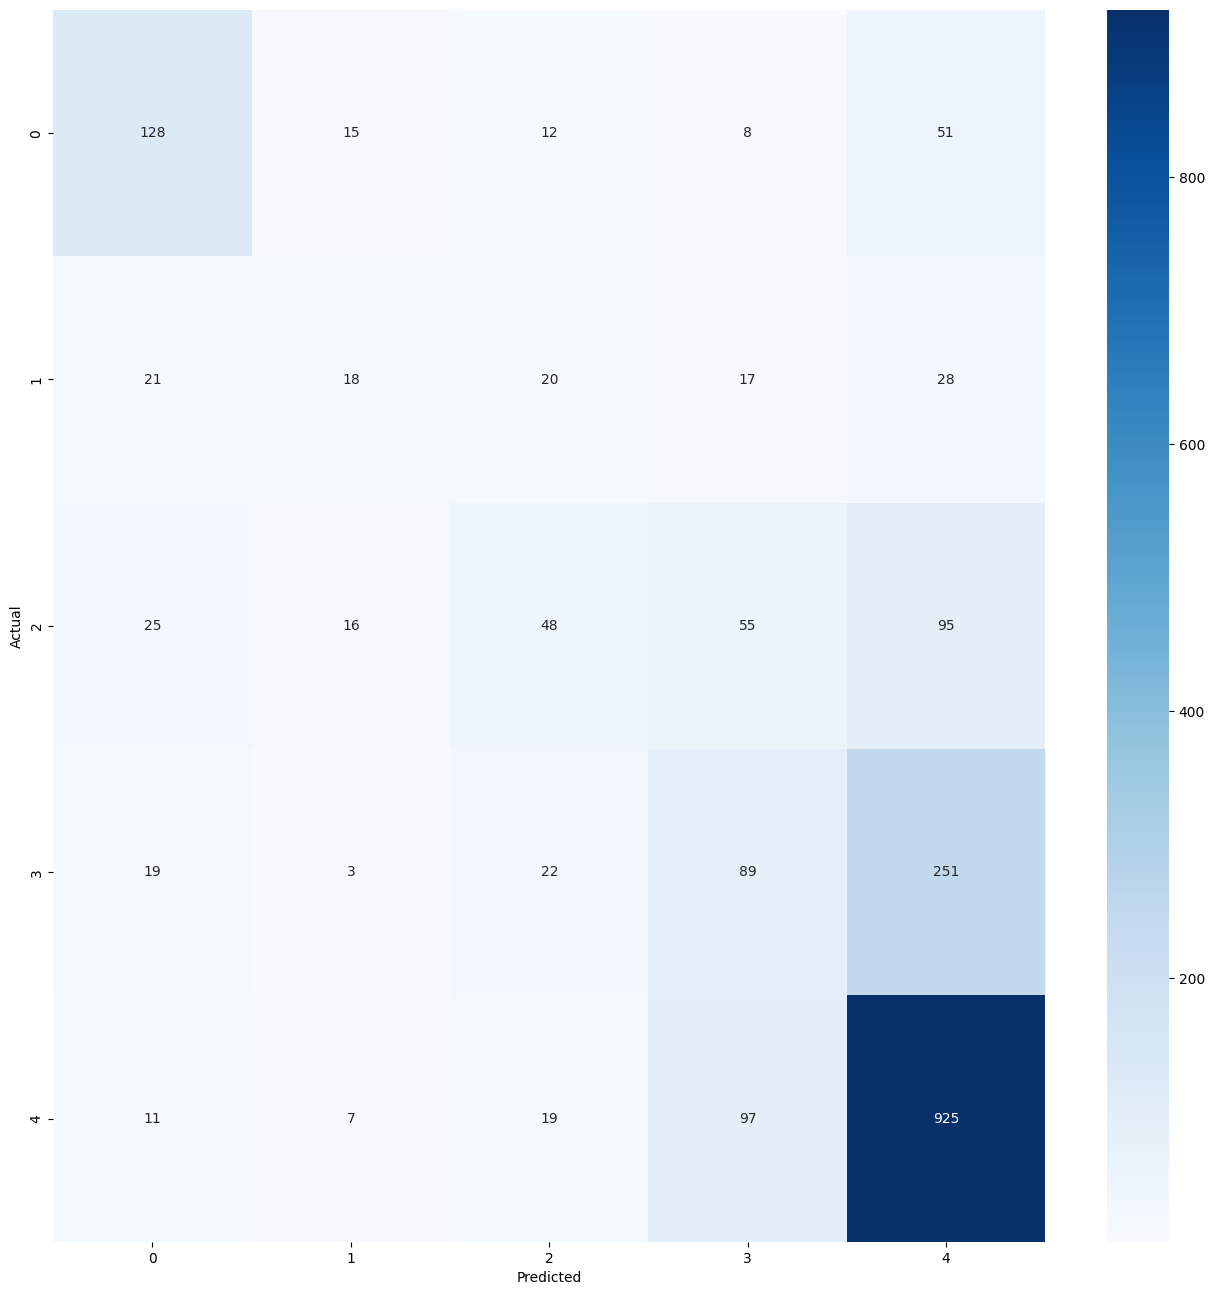

In [22]:
model_knn = KNeighborsClassifier(n_neighbors=6)
model_knn.fit(x_train, y_train)

show_accuracy(y_test, model_knn.predict(x_test.reshape(x_test.shape[0], -1)))

C:\Users\setday\AppData\Roaming\Python\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


0.41096338468304966


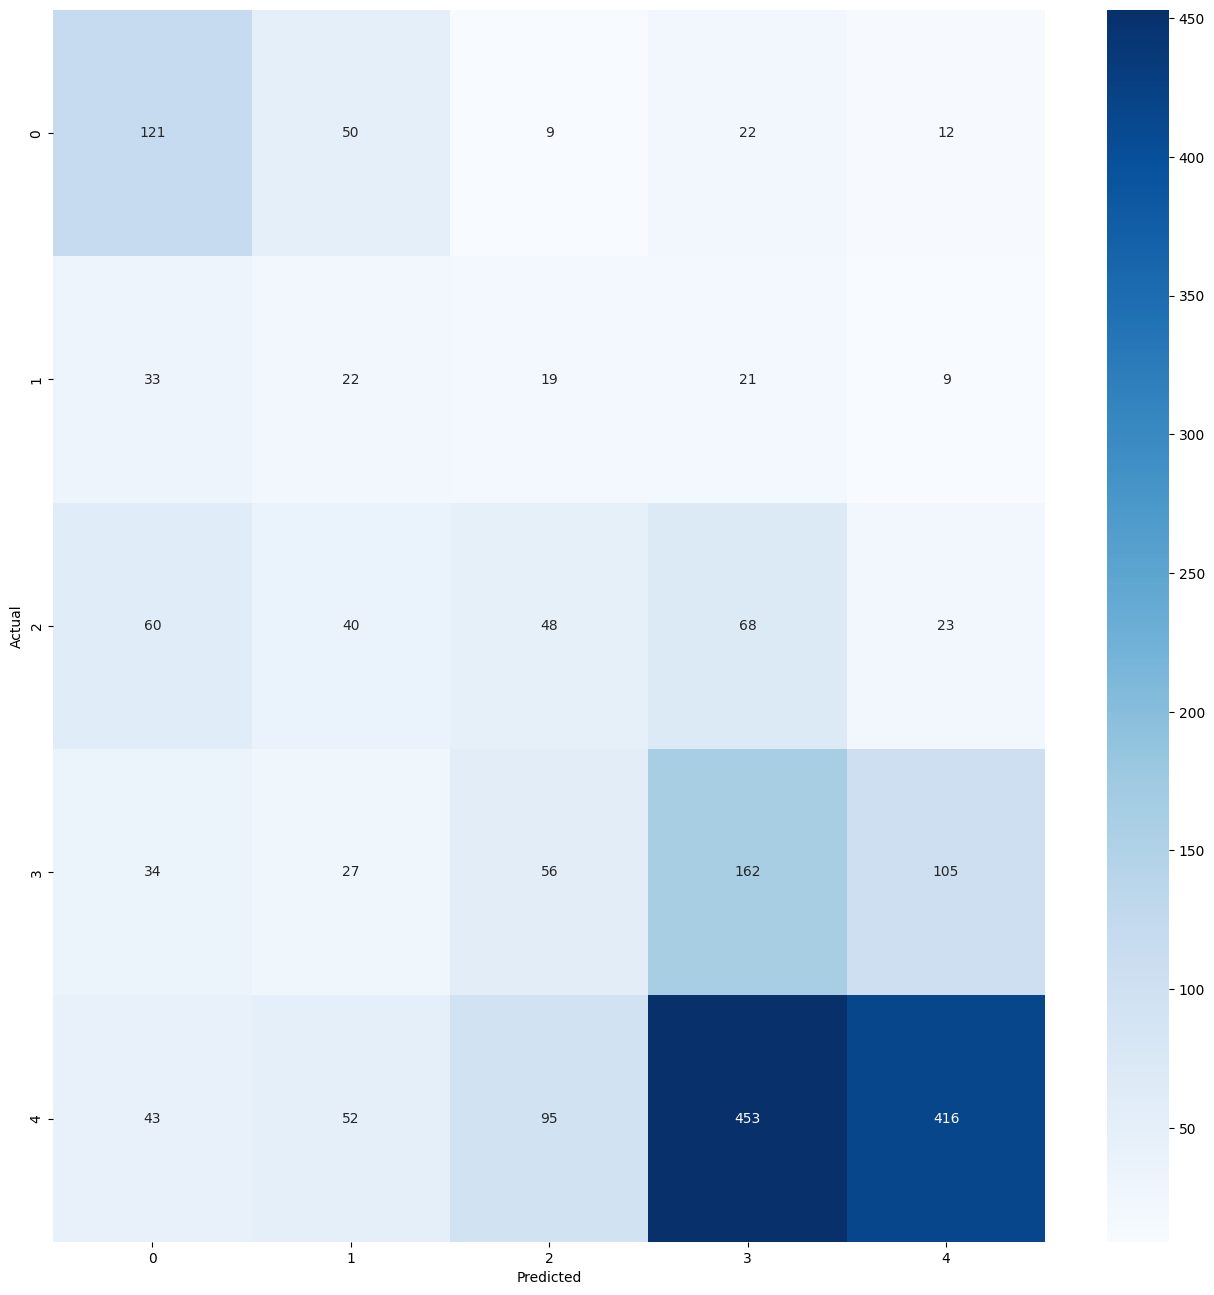

In [13]:
model_SVM_R = SVC(kernel='rbf', max_iter=max_iter//100, cache_size=4000, random_state=113)
model_SVM_R.fit(x_train, y_train)

show_accuracy(y_test, model_SVM_R.predict(x_test.reshape(x_test.shape[0], -1)))

0.5224334397953465


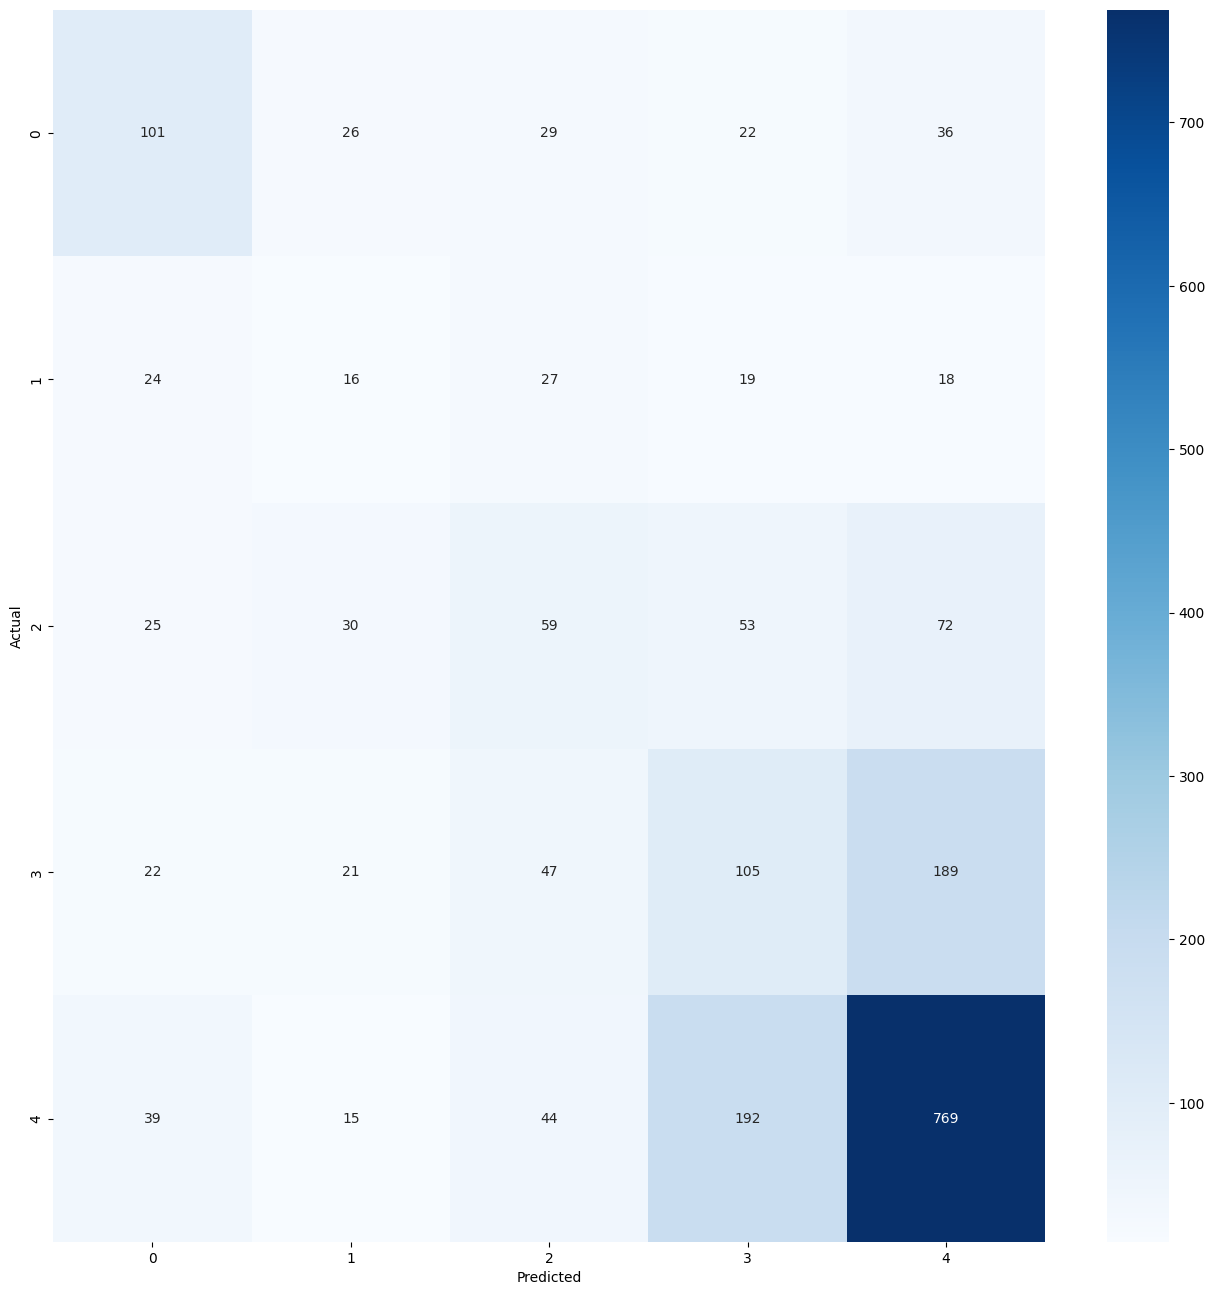

In [15]:
model_DT = DecisionTreeClassifier(max_depth=100, random_state=113)
model_DT.fit(x_train, y_train)

show_accuracy(y_test, model_DT.predict(x_test.reshape(x_test.shape[0], -1)))

0.5397625165257435


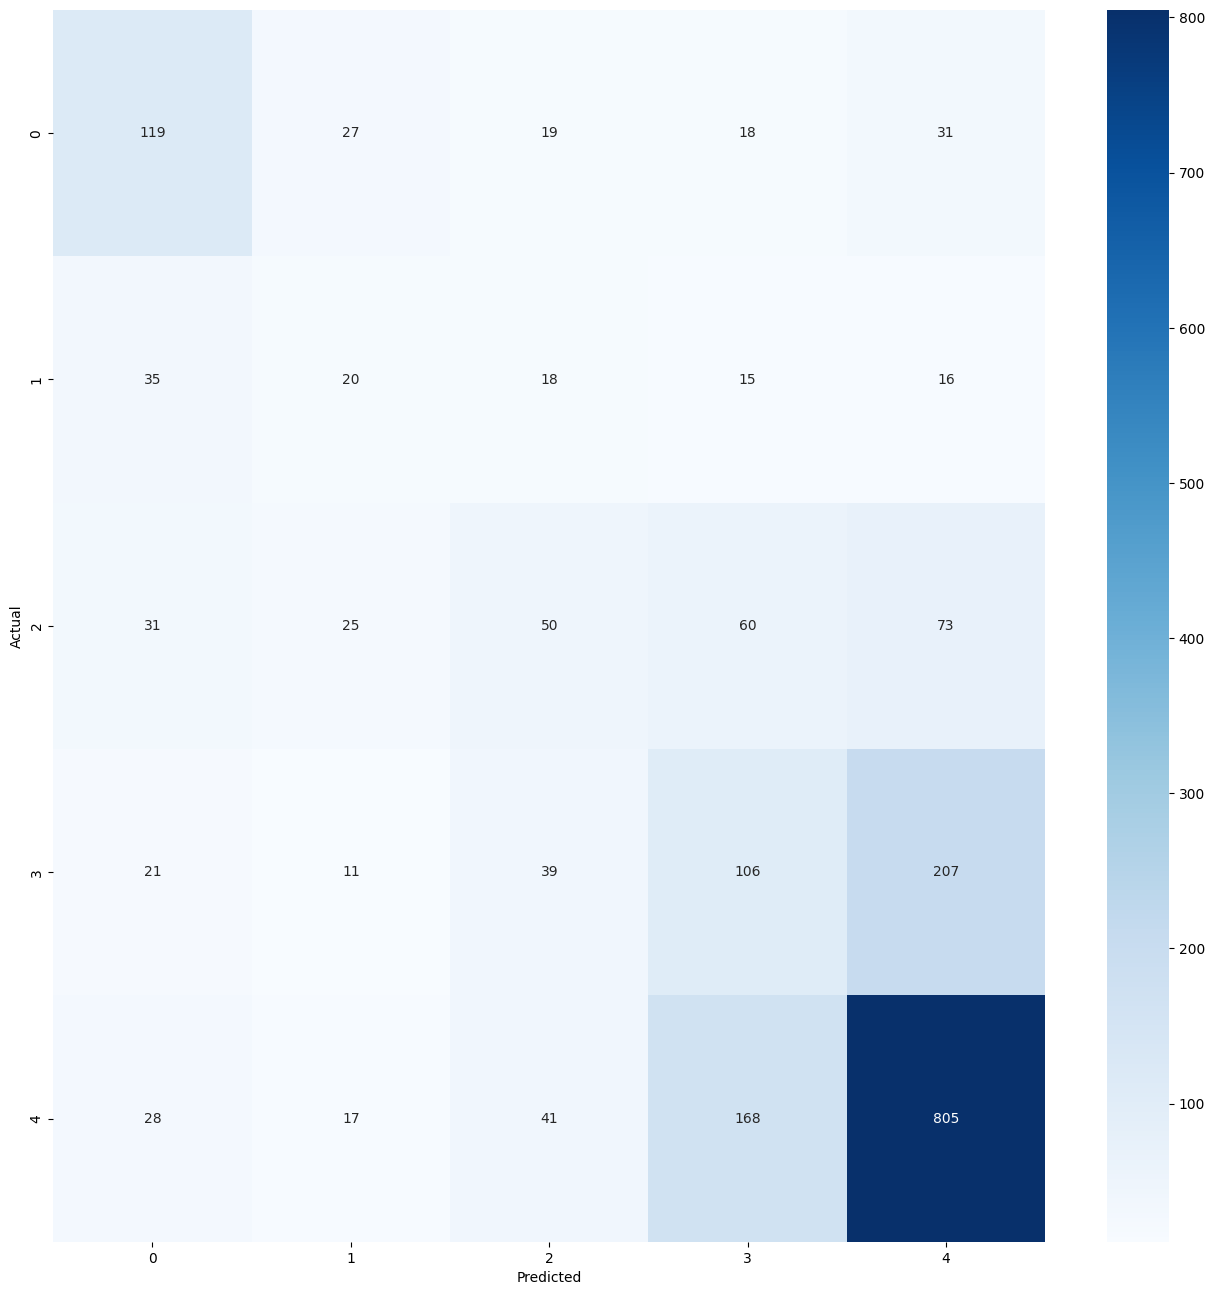

In [16]:
model_DT_R = DecisionTreeRegressor(max_depth=100, random_state=113)
model_DT_R.fit(x_train, y_train)

pred = model_DT_R.predict(x_test.reshape(x_test.shape[0], -1))
pred = np.round(pred).astype(int)

show_accuracy(y_test, pred)

Не удивительно, что регрессия сработала лучше классификации (т.к. градация классов может быть упорядочена). Попробуем для других моделей.

Learning rate set to 0.07058
0:	learn: 1.3144231	test: 1.3206581	best: 1.3206581 (0)	total: 94ms	remaining: 1m 33s
1:	learn: 1.2883709	test: 1.2955681	best: 1.2955681 (1)	total: 174ms	remaining: 1m 26s
2:	learn: 1.2616611	test: 1.2692860	best: 1.2692860 (2)	total: 252ms	remaining: 1m 23s
3:	learn: 1.2393848	test: 1.2479754	best: 1.2479754 (3)	total: 329ms	remaining: 1m 21s
4:	learn: 1.2164021	test: 1.2253616	best: 1.2253616 (4)	total: 403ms	remaining: 1m 20s
5:	learn: 1.1947651	test: 1.2050269	best: 1.2050269 (5)	total: 490ms	remaining: 1m 21s
6:	learn: 1.1748534	test: 1.1855660	best: 1.1855660 (6)	total: 569ms	remaining: 1m 20s
7:	learn: 1.1579049	test: 1.1681831	best: 1.1681831 (7)	total: 649ms	remaining: 1m 20s
8:	learn: 1.1397829	test: 1.1507717	best: 1.1507717 (8)	total: 726ms	remaining: 1m 19s
9:	learn: 1.1243569	test: 1.1371751	best: 1.1371751 (9)	total: 800ms	remaining: 1m 19s
10:	learn: 1.1128597	test: 1.1267854	best: 1.1267854 (10)	total: 883ms	remaining: 1m 19s
11:	learn: 1.

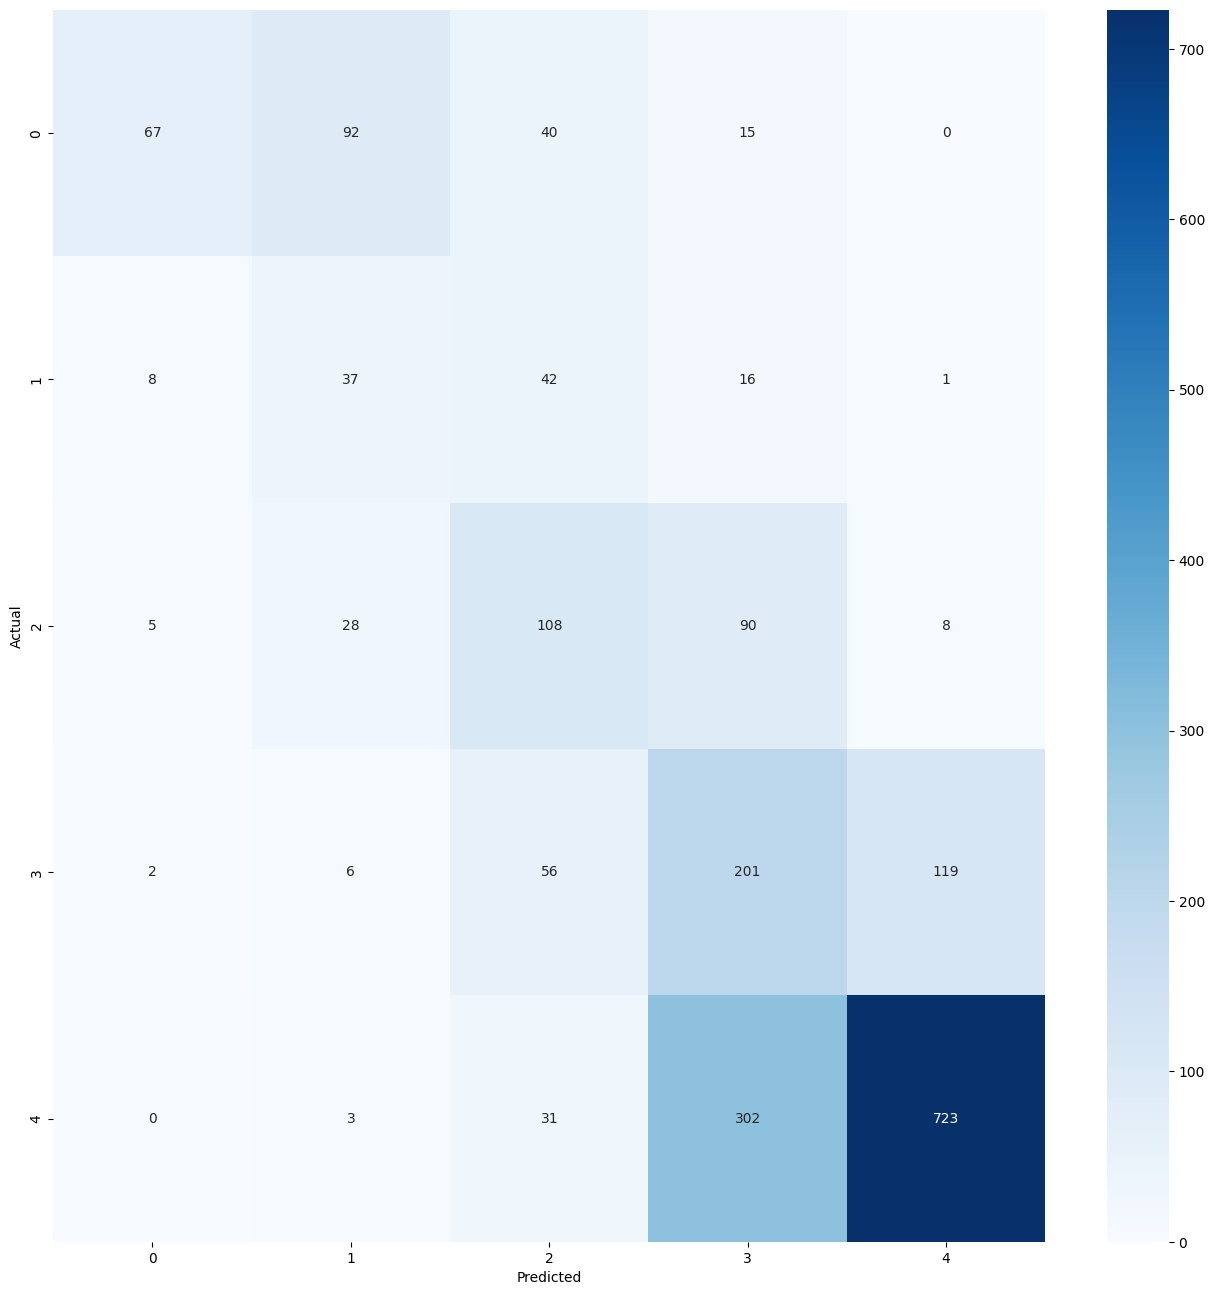

In [22]:
model_CB_R = CatBoostRegressor(iterations=1000, loss_function='RMSE')
model_CB_R.fit(
    x_train, y_train,
    eval_set=(x_test, y_test),
)

pred = model_CB_R.predict(x_test.reshape(x_test.shape[0], -1))
pred = np.round(pred).clip(1, 5).astype(int)

show_accuracy(y_test, pred)

Стало лучше, но победителем всё-таки осталась LogReg. Будем подбирать параметры под неё.

In [26]:
hyperparameters = {
    'tol': [1e-4, 1e-3, 1e-2],
    'C': np.logspace(0, 4, 4),
    'solver': ['liblinear', 'newton-cholesky', 'lbfgs'],
    'max_iter': [max_iter],
    'random_state': [113, 114, 115],
}

search = GridSearchCV(LogisticRegression(), hyperparameters, n_jobs=4, cv=3)
search.fit(x_train, y_train)

print(search.best_params_)

In [ ]:
model = search.best_estimator_
model.fit(x_train, y_train)

show_accuracy(y_test, model.predict(x_test.reshape(x_test.shape[0], -1)))

In [ ]:
my_reviews = [{
    'text' : 'I realy love the flight. There was no turbulence, seats were comfortable. This is definitely the best airline in the world. I will definitely fly with them again.',
    'title' : 'Best airline in the world',
    'rating' : 5
},
{
    'text' : 'I hate this airline. The flight was delayed, the seats were very narrow. But even worse attitude to the luggage. It was completely broken.',
    'title' : 'Bad airplanes with bad service',
    'rating' : 1
},
{
    'text' : 'Nothing special. The flight was normal. The choice of snacks was quite poor, but for such a short flight it is not critical. There was an advertising on every luggage compartment, but for this price it is quite normal.',
    'title' : 'Just a normal flight',
    'rating' : 3
}]

def prefactoring(text, title):
    text = title + ' ' + text
    text = pre_process(text)
    text = remorph(text)
    text = remove_stopwords(text)
    return text

x_my_reviews = tfid.transform([prefactoring(review['text'], review['title']) for review in my_reviews]).toarray()

pred = model.predict(x_my_reviews)
print(pred)
print([review['rating'] for review in my_reviews])


## Hard

Исследовать какие слова полученный алгоритм воспринимает как резко-негативные и резко-позитивные. Научиться систематически обманывать классификатор. Написать 5 положительных и 5 негативных отзывов, где модель будет ошибаться. Важен алгоритм по которому вы составляете эти отзывы, а не сами отзывы.

In [ ]:
my_reviews = [
{
    'text' : 'Other companies are terible: long flight delayes, weak entertament system, the unwillingness of stewards to help in different situations (even in the simplest ones) is striking. But Singapore Airlines is devoid of these disadvantages. Of course, there is space to improve, but now I will only choose this company.',
    'title' : ' Other companies should learn from Singapore Airlines',
    'rating' : 4
}, # tricky case - изначально идет множество негативных вещей, но они относятся к другим компаниям, а не к Singapore Airlines. При этом, когда говорится о Singapore Airlines, для сравнения используются также негативные термины (devoid, disadvantages), несущие позитивный смысл
{
    'text' : 'It was supposed to be the best travel in my life since I haven`t traveled for almost three years. I choose the business class and it was a great decision. The service was excellent due to high expectations of service level in Singapore Airlines. But reality was much worse. The food was tasty, but was served cold. The stewardess was very polite, but she was not able to help me with my problem. The entertainment system was very good, but it was not working properly at my seat. I was very disappointed.',
    'title' : 'Disappointment',
    'rating' : 2
}, # tricky case - опять таки, много хороших слов, но все не отсносятся к Singapore Airlines, а к ожиданиям от него.
]

x_my_reviews = tfid.transform([prefactoring(review['text'], review['title']) for review in my_reviews]).toarray()

pred = model.predict(x_my_reviews)
print(pred)
print([review['rating'] for review in my_reviews])